# EEG Wheelchair Binary Classification ML Model
## Using 1D Convolutional Networks and Recurrent Networks
This is the first experiment with trying to convert 4 channel EEG brain wave data into a binary classification of stop and go for the EEG wheelchair control system.

## Overview
The following notebook will follow these next steps:
1. Data Cleaning
    - Get rid of inconsistent samples or bad samples
2. Data Preprocessing
    - Convert to wavelet transforms and take signal squeezed signals
3. Data Filtering
    - Filter out irrelevant frequencies and disconnections
4. Build Model
    - Form CNN-RNN network for prediction modelling
5. Model Training
    - Train model on training set of EEG Samples
6. Hyperparameter Optimization
    - Optimize model hyperparameters by cross validation 
7. Model Validation
    - Validate model on test set


In [1]:
# Basic imports
from datetime import datetime
import numpy as np
import glob
import os
import sys
from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from time import sleep

# Data management
import pandas as pd

# Data processing
from ssqueezepy import ssq_cwt

# Model training
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, SpatialDropout1D, SpatialDropout2D, BatchNormalization
from tensorflow.keras.layers import Flatten, InputSpec, Layer, Concatenate, AveragePooling2D, MaxPooling2D, Reshape, Permute
from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D, LayerNormalization
from tensorflow.keras.layers import TimeDistributed, Lambda, AveragePooling1D, Add, Conv1D, Multiply
from tensorflow.keras.constraints import max_norm, unit_norm 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
import matplotlib.pyplot as plt

## Experiment Information
Record the experiment information in these fields to be saved with the experiment

In [2]:
trial_num = 4
attempt_num = 2

output_dim = 3
attempt_description = \
"""
## 2nd attempt

### Changes made
- Trying new model on our data
- 200 sample frame
- Testing on compatability dataset

### Expected results
- See if it performs any worse with our Muse model or better than recorded data
- See if it adapts to taking off the headset

### Issues noticed
"""

In [3]:
# Make directories to save data
model_dir = './models/trial%s' % trial_num
results_dir = './results/trial%s/attempt%s' % (trial_num, attempt_num)
interm_dir = './processed_data/trial%s/attempt%s' % (trial_num, attempt_num)

model_file = os.path.join(model_dir, 'attempt%s.h5' % (attempt_num))
summary_file = os.path.join(results_dir, 'attempt%s_summary.txt' % attempt_num)
description_file = os.path.join(results_dir, 'attempt%s_readme.md' % attempt_num)
accuracy_graph = os.path.join(results_dir, 'attempt%s_accuracy.png' % attempt_num)
loss_graph = os.path.join(results_dir, 'attempt%s_loss.png' % attempt_num)
conf_matrix = os.path.join(results_dir, 'attempt%s_confusion.png' % attempt_num)
log_file = os.path.join(results_dir, 'attempt%s.log' % attempt_num)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
if not os.path.exists(interm_dir):
    os.makedirs(interm_dir)
    
# Save description
with open(description_file, 'w') as f:
    f.write(attempt_description)
    f.close()


## Importing Data

In [170]:
# Pull all training files data

# ENTER FILE EXTS HERE
data_path = './datasets/robustness_dataset/'
train_name = 'ridvan_train'
test_name = 'ridvan_test'
val_name = 'ridvan_val'

train_segments = defaultdict(list)
test_segments = defaultdict(list)
val_segments = defaultdict(list)
segment_types = ("GO", "REST", "STOP")
# file_types = ("GO", "REST", "STOP", "REMOVED")

num_train_segments = 1000
num_test_segments = 1000
num_val_segments = 1000

# Get even amounts of all files
for segment_type in segment_types:
    fileglob = os.path.join(data_path, segment_type, '%s_1*.csv' % train_name)
    num_train_segments = min(num_train_segments, len(glob.glob(fileglob)))
    fileglob = os.path.join(data_path, segment_type, '%s_1*.csv' % test_name)
    num_test_segments = min(num_test_segments, len(glob.glob(fileglob)))
    fileglob = os.path.join(data_path, segment_type, '%s_1*.csv' % val_name)
    num_val_segments = min(num_val_segments, len(glob.glob(fileglob)))
    
for segment_type in segment_types:
    fileglob = os.path.join(data_path, segment_type, '%s_1*.csv' % train_name)
    
    for i, file in enumerate(shuffle(glob.glob(fileglob))):
        if i == num_train_segments:
            break
        train_segments[segment_type].append(pd.read_csv(file, header=None).to_numpy()[:,1:])
    
    fileglob = os.path.join(data_path, segment_type, '%s_1*.csv' % test_name)
    
    for i, file in enumerate(shuffle(glob.glob(fileglob))):
        if i == num_test_segments:
            break
        test_segments[segment_type].append(pd.read_csv(file, header=None).to_numpy()[:,1:])
    
    fileglob = os.path.join(data_path, segment_type, '%s_1*.csv' % val_name)
    
    for i, file in enumerate(shuffle(glob.glob(fileglob))):
        if i == num_val_segments:
            break
        val_segments[segment_type].append(pd.read_csv(file, header=None).to_numpy()[:,1:])
        
print("Training: ")
for val in segment_types:
    print('    There are %d segments with %s label' % (len(train_segments[val]), val))
    
print("Testing: ")
for val in segment_types:
    print('    There are %d segments with %s label' % (len(test_segments[val]), val))
    
print("Validation: ")
for val in segment_types:
    print('    There are %d segments with %s label' % (len(val_segments[val]), val))
    

Training: 
    There are 58 segments with GO label
    There are 58 segments with REST label
    There are 58 segments with STOP label
Testing: 
    There are 9 segments with GO label
    There are 9 segments with REST label
    There are 9 segments with STOP label
Validation: 
    There are 11 segments with GO label
    There are 11 segments with REST label
    There are 11 segments with STOP label


## Convert to wavelet transform signal squeezed

In [173]:
original_frame_size = 3000
buffer_frame_size = 200
training_frame_size = 200


key_dict = {"GO":(1.0, 0.0, 0.0),
            "STOP":(0.0, 1.0, 0.0),
            "REST": (0.0, 0.0, 1.0)}


def compile_segments(segments, seg_type):
    X = []
    t = []
    
    num_segments = sum([len(x) for x in segments.values()])
    
    for key, data in segments.items():
        for recording in data:
            # if segment is smaller than sample size
            if len(recording) < original_frame_size:
                continue

            # Split file into buffer size samples
            time_samples = np.split(recording[:original_frame_size],
                                    int(original_frame_size/buffer_frame_size))

            for time_sample in time_samples:
                # Convert to numpy arrays
#                 ssq_data = ts_to_ssq(time_sample)

#                 # Take the magnitude of the wavelet transform only
#                 ssq_data = np.abs(ssq_data)
                
#                 # Trim unwanted frequencies
#                 ssq_data = ssq_data[:,:MAX_FREQ, :]

#                 # Split sample into many blocks
#                 wavelet_samples = np.dsplit(ssq_data, int(buffer_frame_size/training_frame_size))
                time_frames = np.split(time_sample, int(buffer_frame_size/training_frame_size))

                X.extend(time_frames)
                t.extend([key_dict[key] for i in range(len(time_frames))])
                
            num_segments -= 1
            
            print("%d %s segments left to convert " % (num_segments, seg_type), end="\r")
                
    return np.array(X).astype(np.float32), np.array(t).astype(np.float32)

In [174]:
# Compile all files into train data
X_train, t_train = compile_segments(train_segments, 'train')

X_test, t_test = compile_segments(test_segments, 'test')

X_val, t_val = compile_segments(val_segments, 'val')

In [175]:
# Reshape the data for training
X_train = X_train.transpose(0, 2, 1)

X_test = X_test.transpose(0, 2, 1)

# Reshape the data for training
X_val = X_val.transpose(0, 2, 1)

In [176]:
print("Training data")
print(X_train.shape)
print(t_train.shape)
print("Testing data")
print(X_test.shape)
print(t_test.shape)
print("Validation data")
print(X_val.shape)
print(t_val.shape)

Training data
(2595, 4, 200)
(2595, 3)
Testing data
(405, 4, 200)
(405, 3)
Validation data
(495, 4, 200)
(495, 3)


In [177]:
# Save the ssq data
np.save(os.path.join(interm_dir, 'x_train.npy'), X_train)
np.save(os.path.join(interm_dir, 't_train.npy'), t_train)
np.save(os.path.join(interm_dir, 'x_test.npy'), X_test)
np.save(os.path.join(interm_dir, 't_test.npy'), t_test)
np.save(os.path.join(interm_dir, 'x_val.npy'), X_val)
np.save(os.path.join(interm_dir, 't_val.npy'), t_val)


## *Shortcut: Load Preprocessed Saved Data*

In [4]:
# Load ssq data
X_train = np.load(os.path.join(interm_dir, 'x_train.npy'))
t_train = np.load(os.path.join(interm_dir, 't_train.npy'))
X_test = np.load(os.path.join(interm_dir, 'x_test.npy'))
t_test = np.load(os.path.join(interm_dir, 't_test.npy'))
X_val = np.load(os.path.join(interm_dir, 'x_val.npy'))
t_val = np.load(os.path.join(interm_dir, 't_val.npy'))

## Shuffle data

In [5]:
# Shuffle the data
X_train, t_train = shuffle(X_train, t_train)
X_test, t_test = shuffle(X_test, t_test)
X_val, t_val = shuffle(X_val, t_val)

In [ ]:
X_train_full = X_train
X_train = X_train[:100]
t_train_full = t_train
t_train = t_train[:100]

In [179]:
X_train.shape

(2595, 4, 200)

In [180]:
t_train.shape

(2595, 3)

In [181]:
np.argwhere(np.isnan(X_train))

array([], shape=(0, 3), dtype=int64)

In [ ]:
counts = [0, 0, 0]
for data in t_train:
    for i in range(3):
        if data[i] == 1:
            counts[i] += 1
  
print("Balance of categories")
print(counts)

## Train Model

In [8]:
num_frames = len(X_train)
num_channels = len(X_train[0])
frame_size = len(X_train[0][0])

print('Training data dimensions = (%s, %s, %s)' % (num_frames, num_channels, frame_size))

n_ff = [2,4,8,16]    # Number of frequency filters for each inception module of EEG-ITNet
n_sf = [1,1,1,1]     # Number of spatial filters in each frequency sub-band of EEG-ITNet

drop_rate = 0.2

# Input layer
input_layer = Input(shape=(num_channels, frame_size, 1))

block1 = Conv2D(n_ff[0], (1, 16), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_1')(input_layer)
block1 = BatchNormalization()(block1)
block1 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[0], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_1')(block1)
block1 = BatchNormalization()(block1)
block1 = Activation('elu')(block1)

#================================

block2 = Conv2D(n_ff[1], (1, 32), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_2')(input_layer)
block2 = BatchNormalization()(block2)
block2 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[1], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_2')(block2)
block2 = BatchNormalization()(block2)
block2 = Activation('elu')(block2)

#================================

block3 = Conv2D(n_ff[2], (1, 64), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_3')(input_layer)
block3 = BatchNormalization()(block3)
block3 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[2], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_3')(block3)
block3 = BatchNormalization()(block3)
block3 = Activation('elu')(block3)

#================================

block4 = Conv2D(n_ff[3], (1, 128), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_4')(input_layer)
block4 = BatchNormalization()(block4)
block4 = DepthwiseConv2D((num_channels, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[3], activation = 'linear', 
                       depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_4')(block4)
block4 = BatchNormalization()(block4)
block4 = Activation('elu')(block4)

#================================

block = Concatenate(axis = -1)([block1, block2, block3, block4]) 

#================================

block = AveragePooling2D((1, 4))(block)
block_in = Dropout(drop_rate)(block)

#================================

paddings = tf.constant([[0,0], [0,0], [3,0], [0,0]])
block = tf.pad(block_in, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 1))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 1))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_in, block])


paddings = tf.constant([[0,0], [0,0], [6,0], [0,0]])
block = tf.pad(block_out, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 2))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 2))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_out, block])


paddings = tf.constant([[0,0], [0,0], [12,0], [0,0]])
block = tf.pad(block_out, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 4))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 4))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_out, block]) 


paddings = tf.constant([[0,0], [0,0], [24,0], [0,0]])
block = tf.pad(block_out, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 8))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block = tf.pad(block, paddings, "CONSTANT")
block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 8))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = Dropout(drop_rate)(block)
block_out = Add()([block_out, block]) 

#================================

block = block_out

#================================

block = Conv2D(28, (1,1))(block)
block = BatchNormalization()(block)
block = Activation('elu')(block)
block = AveragePooling2D((1,4), data_format='Channels_last')(block) #'Channels_last' As CPU will be used for inference
block = Dropout(drop_rate)(block) 
embedded = Flatten()(block)

output = Dense(len(t_train[0]), activation='softmax', kernel_constraint = max_norm(0.2))(embedded)
    
model = Model(inputs=input_layer, outputs=output)
    

Training data dimensions = (2595, 4, 200)


In [9]:
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipvalue=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
with open(summary_file, 'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    fh.close()
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 200, 1)]  0                                            
__________________________________________________________________________________________________
Spectral_filter_1 (Conv2D)      (None, 4, 200, 2)    32          input_1[0][0]                    
__________________________________________________________________________________________________
Spectral_filter_2 (Conv2D)      (None, 4, 200, 4)    128         input_1[0][0]                    
__________________________________________________________________________________________________
Spectral_filter_3 (Conv2D)      (None, 4, 200, 8)    512         input_1[0][0]                    
______________________________________________________________________________________________

In [185]:
model.get_weights()

[array([[[[ 0.34511027, -0.23284996]],
 
         [[ 0.13644445,  0.20883706]],
 
         [[-0.08111042, -0.32665905]],
 
         [[-0.2985261 ,  0.09822315]],
 
         [[-0.32746178,  0.13879085]],
 
         [[ 0.1138286 ,  0.13647866]],
 
         [[-0.14517945, -0.1476308 ]],
 
         [[ 0.02621982,  0.27260008]],
 
         [[ 0.30531886,  0.23285499]],
 
         [[-0.30644375, -0.128434  ]],
 
         [[ 0.3157253 , -0.21183461]],
 
         [[-0.24044752,  0.24948356]],
 
         [[ 0.3390021 , -0.22956493]],
 
         [[-0.28081644, -0.21171221]],
 
         [[ 0.3184941 ,  0.07462901]],
 
         [[-0.20002945,  0.3286858 ]]]], dtype=float32),
 array([[[[ 0.12480861, -0.18641938, -0.01844829,  0.04314305]],
 
         [[-0.0396681 ,  0.13037392,  0.07755262,  0.11490062]],
 
         [[-0.18340586,  0.11235884,  0.05176304,  0.06025225]],
 
         [[ 0.12732512,  0.14839715,  0.07420948, -0.05119835]],
 
         [[ 0.13746175,  0.17431226,  0.1396425 ,  0.1397902

In [11]:
stdout = sys.stdout
f = open(log_file, 'w')
sys.stdout = f
try:
    results = model.fit(X_train, t_train, validation_data=(X_val, t_val), batch_size=32, epochs=50, shuffle=True)
    sys.stdout = stdout
    f.close()
except Exception as e:
    print(e)
    sys.stdout = stdout
    f.close()

2023-02-27 22:32:58.916818: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-27 22:32:59.118929: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


In [241]:
sys.stdout = stdout
f.close()

In [188]:
# To save the model
model.save(model_file)

In [6]:
model = tf.keras.models.load_model(model_file)

2023-02-27 22:32:07.395019: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-02-27 22:32:07.446571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Tesla K20Xm computeCapability: 3.5
coreClock: 0.732GHz coreCount: 14 deviceMemorySize: 5.57GiB deviceMemoryBandwidth: 232.46GiB/s
2023-02-27 22:32:07.447041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 22:32:07.449807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-27 22:32:07.451802: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-27 22:32:07.452260: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-

In [12]:
test_results = model.evaluate(X_test, t_test, batch_size = 1)

405/405 [==============================] - 3s 7ms/step - loss: 1.1122 - accuracy: 0.4444


In [192]:
model.predict(X_test)

array([[0.11435271, 0.26972103, 0.61592627],
       [0.593456  , 0.24304432, 0.16349968],
       [0.5486732 , 0.40846807, 0.04285868],
       ...,
       [0.7755368 , 0.1786613 , 0.04580196],
       [0.3972842 , 0.5287353 , 0.07398049],
       [0.26209897, 0.5036143 , 0.23428673]], dtype=float32)

In [193]:
t_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

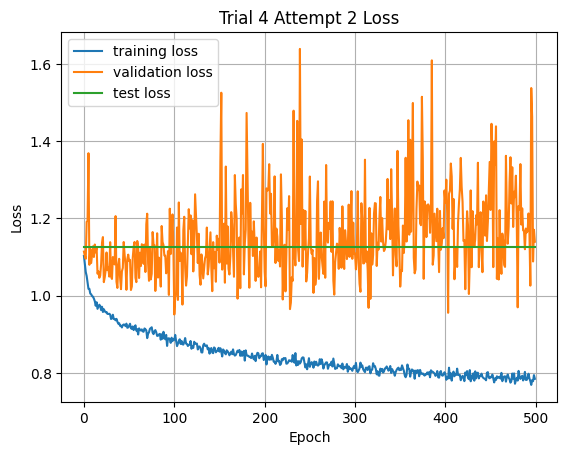

In [194]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.plot([test_results[0] for i in range(len(results.history['loss']))])
plt.legend(('training loss', 'validation loss', 'test loss'))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Trial %s Attempt %s Loss" % (trial_num, attempt_num))
plt.grid()
plt.savefig(loss_graph)

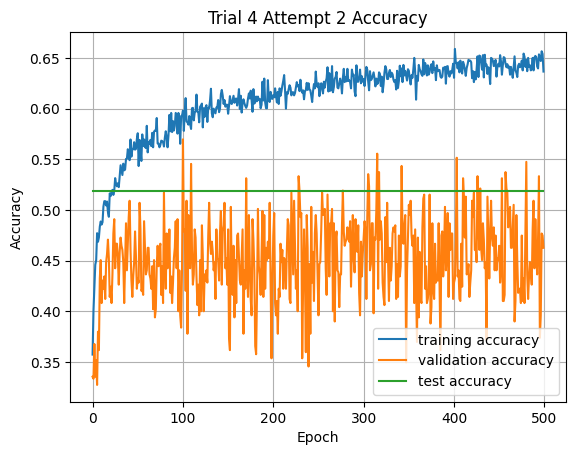

In [195]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.plot([test_results[1] for i in range(len(results.history['accuracy']))])
plt.legend(('training accuracy', 'validation accuracy', 'test accuracy'))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Trial %s Attempt %s Accuracy" % (trial_num, attempt_num))
plt.grid()
plt.savefig(accuracy_graph)

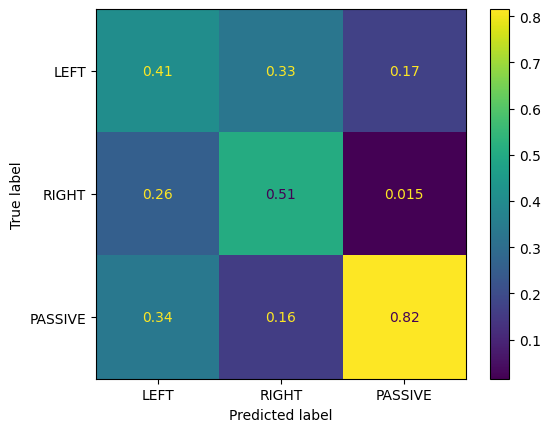

In [196]:
key_dict = {"LEFT":(1.0, 0.0, 0.0),
            "RIGHT":(0.0, 1.0, 0.0),
            "PASSIVE": (0.0, 0.0, 1.0)}

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(t_test, axis=1)

cm = confusion_matrix(y_test, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=key_dict.keys())
plot = disp.plot()
disp.figure_.savefig(conf_matrix)

In [168]:
tf.keras.backend.clear_session()

# Model Visualization

(4, 200)


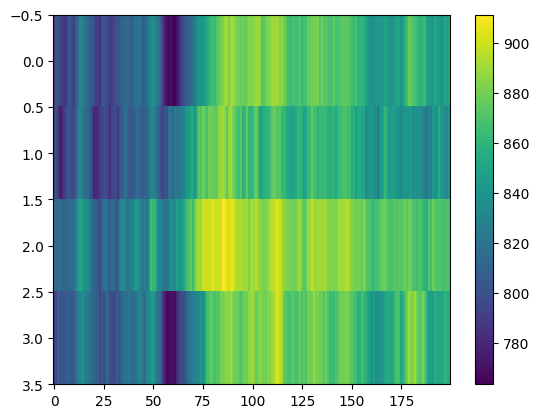

In [21]:
print(X_test[0].shape)
plt.imshow(X_test[0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [14]:
spectral_filter_1 = Model(inputs=input_layer, outputs=block1)

(1, 1, 200, 2)


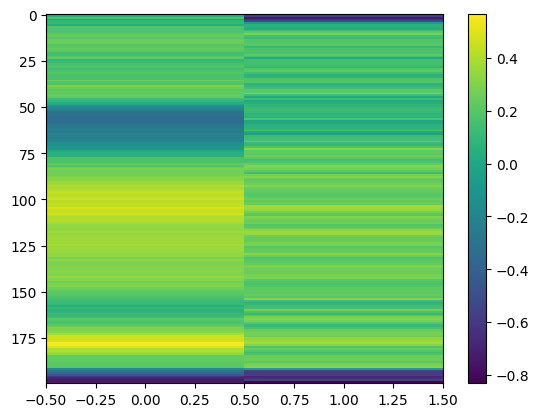

In [16]:
output = spectral_filter_1.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [18]:
all_spectral_filter = Model(inputs=input_layer, outputs=block_in)

(1, 1, 50, 30)


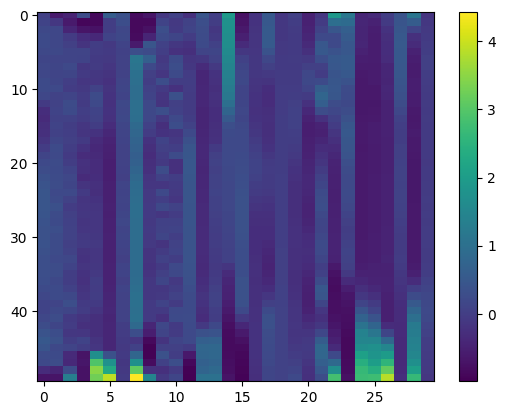

In [19]:
output = all_spectral_filter.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [18]:
all_spectral_filter = Model(inputs=input_layer, outputs=block_in)

(1, 1, 50, 30)


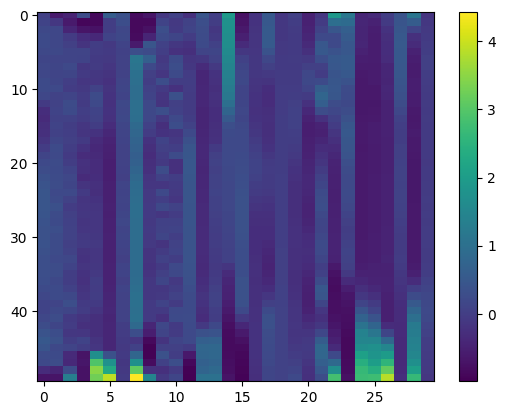

In [19]:
output = all_spectral_filter.predict(X_test[:1])
print(output.shape)
plt.imshow(output[0][0], interpolation='nearest', aspect='auto')
plt.colorbar()